### Import Packages and Dependencies

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Input, Dropout, Flatten, Dense, Activation
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from keras.utils import np_utils
from livelossplot import PlotLossesKeras
from keras.callbacks import CSVLogger
import os, cv2, random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import ticker
%matplotlib inline 



Using TensorFlow backend.


### Load Data

In [2]:
# define constants
MODEL_FILE = "model.h5"
MODEL_SUMMARY_FILE = "model_summary.txt"
TEST_FILE = "test_file.txt"
TRAINING_LOGS_FILE = "training_logs.csv"

ROWS = 200
COLS = 200
BATCH_SIZE = 32
TEST_SIZE = 30
EPOCHS = 20
CHANNELS = 3
input_shape = (ROWS, COLS, 3)

# data directories
train_dir = 'data/train'
test_dir = 'data/test'


### Regularization by Data Augmentation


In [3]:
training_data_gen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        validation_split=0.2)

test_data_gen = ImageDataGenerator(rescale=1./255)

### Data Pre-Processing

In [4]:
training_gen = training_data_gen.flow_from_directory(
    train_dir,
    target_size=(COLS, ROWS),
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="training")

validation_gen = training_data_gen.flow_from_directory(
    train_dir,
    target_size=(COLS, ROWS),
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="validation")

test_gen = test_data_gen.flow_from_directory(
    test_dir,
    target_size=(COLS, ROWS),
    batch_size=1,
    class_mode="binary", 
    shuffle=False)



Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


### Models

In [5]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding ='same', input_shape=input_shape, activation='relu'))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1))
model.add(Activation('sigmoid'))
    
model.compile(loss='binary_crossentropy',
            optimizer=RMSprop(lr=0.0001),
            metrics=['accuracy'])

### Training and Predictions

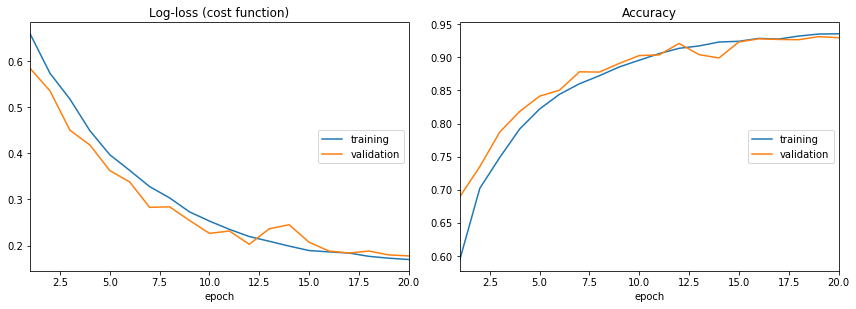

Log-loss (cost function):
training   (min:    0.170, max:    0.659, cur:    0.170)
validation (min:    0.178, max:    0.584, cur:    0.178)

Accuracy:
training   (min:    0.595, max:    0.936, cur:    0.936)
validation (min:    0.690, max:    0.931, cur:    0.930)


In [6]:
history = model.fit_generator(
          training_gen,
          steps_per_epoch=len(training_gen.filenames) // BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=validation_gen,
          validation_steps=len(validation_gen.filenames) // BATCH_SIZE,
          callbacks=[PlotLossesKeras(), CSVLogger(TRAINING_LOGS_FILE,
                                                        append=False,
                                                        separator=";")], 
                                                            verbose=1)

model.save_weights(MODEL_FILE)

predictions = model.predict_generator(test_gen, TEST_SIZE)

In [8]:
for i in range(0,10):
    if predictions[i, 0] >= 0.5: 
        print(' {:.2%} Dog'.format(predictions[i][0]))
    else: 
        print(' {:.2%} Cat'.format(1-predictions[i][0]))
    plt.show()
    

 99.98% Dog
 100.00% Cat
 79.34% Dog
 99.91% Dog
 67.16% Cat
 100.00% Cat
 99.72% Cat
 99.98% Dog
 75.57% Dog
 100.00% Cat
